<a href="https://colab.research.google.com/github/afifrizkyandika11551100310/Sentiment_analysis_LSTM/blob/main/23521034_M_Afif_Rizky_A_BitHealth_Sentimen_Analysis_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Architecture Sentiment Analysis Model BitHealth**

**Nama : M Afif Rizky A <br>
Nim : 23521034 <br>
Asal Universitas : Institut Teknologi Bandung <br>**

## Library Dependecy and Options Setting 

In [ ]:
! pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 5.1 MB/s eta 0:00:00


In [ ]:
! pip install --upgrade gensim

In [ ]:
# library dependency
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# setting pandas dataframe
pd.set_option('display.max_colwidth', None)

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Word2vec
import gensim

# Utility
import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import string
import unicodedata
import chardet
import datetime
nltk.download('punkt')
nltk.download('stopwords')

#keras
# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report

# Deep Learing Preprocessing - Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, pad_sequences

# Deep Learning Model - Keras
from keras.models import Model
from keras.models import Sequential

# Deep Learning Model - Keras - CNN
from keras.layers import Conv1D, Conv2D, Convolution1D, MaxPooling1D, SeparableConv1D, SpatialDropout1D, GlobalAvgPool1D, GlobalMaxPool1D, GlobalMaxPooling1D 
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import MaxPooling3D, GlobalMaxPooling3D, GlobalAveragePooling3D


# Deep Learning Model - Keras - RNN
from keras.layers import Embedding, LSTM, Bidirectional

# Deep Learning Model - Keras - General
from keras.layers import Input, Add, concatenate, Dense, Activation, BatchNormalization, Dropout, Flatten
from keras.layers import LeakyReLU, PReLU, Lambda, Multiply

# Deep Learning Parameters - Keras
from keras.optimizers import RMSprop, Adam

# Deep Learning Callbacs - Keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight as cw

# Time
import time
import datetime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Read TSV file
df = pd.read_csv('/content/drive/MyDrive/BitHealth/data_training.tsv.txt', delimiter='\t')

#print columns
df.columns = ['Text', 'Label']

#print dataset head
df.head()

,Text,Label
0,mohon ulama lurus dan k212 mmbri hujjah partai apa yang harus diwlh agar suara islam tidak pecah-pecah,neutral
1,"lokasi strategis di jalan sumatera bandung . tempat nya nyaman terutama sofa di lantai 2 . paella nya enak , sangat pas dimakan dengan minum bir dingin . appetiser nya juga enak-enak .",positive
2,betapa bahagia nya diri ini saat unboxing paket dan barang nya bagus ! menetapkan beli lagi !,positive
3,"duh . jadi mahasiswa jangan sombong dong . kasih kartu kuning segala . belajar dulu yang baik , tidak usahlah ikut-ikut politik . nanti sudah selesai kuliah nya mau ikut politik juga tidak telat . dasar mahasiswa .",negative
4,"makanan beragam , harga makanan di food stall akan ditambahkan 10 % lagi di kasir , suasana ramai dan perlu perhatian untuk mendapatkan parkir dan tempat duduk .",positive


## Preprocessing Steps

In [ ]:
with open('/content/drive/MyDrive/BitHealth/data_kamusalay.csv', 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

# kamus normalisasi 
with open('/content/drive/MyDrive/BitHealth/data_kamusalay.csv', 'r', encoding=encoding) as f:
    slang_dict = {}
    for line in f:
        word, definition = line.strip().split(',')
        slang_dict[word] = definition
    
    
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#Emoji patterns
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

#normalisasi text - ubah bahasa tidak baku menjadi baku dengan menggunakan kamus
def normalize_text(str):
    # Normalize slang words
    for word in str.split():
        if word in slang_dict:
            str = str.replace(word, slang_dict[word])
    return str

#remove stopwords
def removeStopword(str):
    stop_words = set(stopwords.words('indonesian'))
    word_tokens = word_tokenize(str)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)


#remove sentence which contains only one word
def removeSentence(str): 
    word = str.split()
    wordCount = len(word)
    if(wordCount <= 1):
        str = ''
    return str


# remove encoded emojis
def removeEmojis(str): 
    emoji_pattern = re.compile("(:[a-z_]+:)", re.UNICODE)
    str = emoji_pattern.sub("", str)
    return str


def cleaning(str):
    #remove non-ascii
    str = unicodedata.normalize('NFKD', str).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #remove URLs
    str = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', str)
    #remove punctuations
    str = re.sub(r'[^\w]|_',' ',str)
    #remove @username 
    str = re.sub('@[^\s]+', '',str)
    #remove digit from string
    str = re.sub("\S*\d\S*", "", str).strip()
    #remove digit or numbers
    str = re.sub(r"\b\d+\b", " ", str)
    #to lowercase
    str = str.lower()
    #Remove additional white spaces
    str = re.sub('[\s]+', ' ', str)
    # remove hashtag
    str = re.sub(r'#([^\s]+)', '', str)
    # Remove simbol, angka dan karakter aneh
    str = re.sub(r"[.,:;+!\-_<^/=?\"'\(\)\d\*]", " ", str)
    # trim
    str = str.strip('\'"') 
    #replace consecutive non-ASCII characters with a space
    str = re.sub(r'[^\x00-\x7F]+', '', str)
    # remove specific words
    to_remove = ['user', 'httpurl', 'anot', 'deh' 'crying', 'crying', 'iya', 'banget', 
                 'retweet', 'loudly', 'face', 'with', 'wayv', "thumbs", "nct", "dream", 
                 "wk", "warning", "yuk", 'wib', 'sweat', 'muhammad', 'sleeper', 'beaming', 
                 'laughing', 'rolling', 'smiling', 'eyes', 'grinning', 'skin', 'hands', 'folded', 'kpop', 'idol',]
    str = re.sub("|".join(to_remove), "", str)
    # remove specific patterns
    strings_to_remove = r'\b(rt|wk|gk|ga)\b'
    str = re.sub(strings_to_remove, '', str, flags=re.IGNORECASE)
    # remove emojis from tweet
    str = emoji_pattern.sub(r'', str)
    return str

def preprocessing(str):
    str = removeSentence(str)
    str = removeEmojis(str)
    str = cleaning(str)
    str = normalize_text(str)
    str = cleaning(str)
    str = removeStopword(str)
    
    return str

In [ ]:
# apply preprocessing
df['cleaned_text'] = df['Text'].apply(preprocessing)

#display result
df.head()

,Text,Label,cleaned_text
0,mohon ulama lurus dan k212 mmbri hujjah partai apa yang harus diwlh agar suara islam tidak pecah-pecah,neutral,mohon ulama lurus mmbri hujjah partai diwlh suara islam pecah pecah
1,"lokasi strategis di jalan sumatera bandung . tempat nya nyaman terutama sofa di lantai 2 . paella nya enak , sangat pas dimakan dengan minum bir dingin . appetiser nya juga enak-enak .",positive,lokasi strategis jalan sumatra bandung nya nyaman sofa lantai paella nya enak pas dimakan minum bir dingin appetiser nya enak enak
2,betapa bahagia nya diri ini saat unboxing paket dan barang nya bagus ! menetapkan beli lagi !,positive,betapa bahagia nya unboxing paket barang nya bagus menetapkan beli
3,"duh . jadi mahasiswa jangan sombong dong . kasih kartu kuning segala . belajar dulu yang baik , tidak usahlah ikut-ikut politik . nanti sudah selesai kuliah nya mau ikut politik juga tidak telat . dasar mahasiswa .",negative,aduh mahasiswa sombong kasih kartu kuning belajar usahlah politik selesai kuliah nya politik telat dasar mahasiswa
4,"makanan beragam , harga makanan di food stall akan ditambahkan 10 % lagi di kasir , suasana ramai dan perlu perhatian untuk mendapatkan parkir dan tempat duduk .",positive,makanan beragam harga makanan food stall kasir suasana ramai perhatian parkir duduk


## Analisis dan Visualisasi Dataset

In [ ]:
new_df = df[['cleaned_text', 'Label']]
new_df.head()

,cleaned_text,Label
0,mohon ulama lurus mmbri hujjah partai diwlh suara islam pecah pecah,neutral
1,lokasi strategis jalan sumatra bandung nya nyaman sofa lantai paella nya enak pas dimakan minum bir dingin appetiser nya enak enak,positive
2,betapa bahagia nya unboxing paket barang nya bagus menetapkan beli,positive
3,aduh mahasiswa sombong kasih kartu kuning belajar usahlah politik selesai kuliah nya politik telat dasar mahasiswa,negative
4,makanan beragam harga makanan food stall kasir suasana ramai perhatian parkir duduk,positive


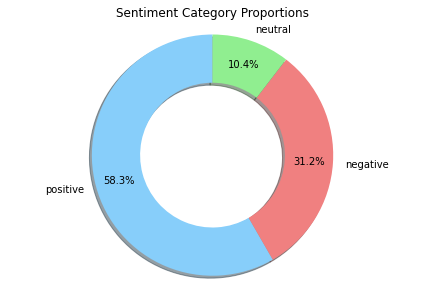

In [ ]:
# analisis label

def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle = angle, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()
    
# Plot arguments
sizes = new_df.Label.value_counts()
labels = ['positive' , 'negative', 'neutral']
colors = ['lightskyblue', 'lightcoral', 'lightgreen']
explode = (0,0,0)

# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Sentiment Category Proportions')

plt.show()

In [ ]:
temp = new_df.groupby('Label').count()['cleaned_text'].reset_index().sort_values(by='cleaned_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Label,cleaned_text
2,positive,6415
0,negative,3436
1,neutral,1148


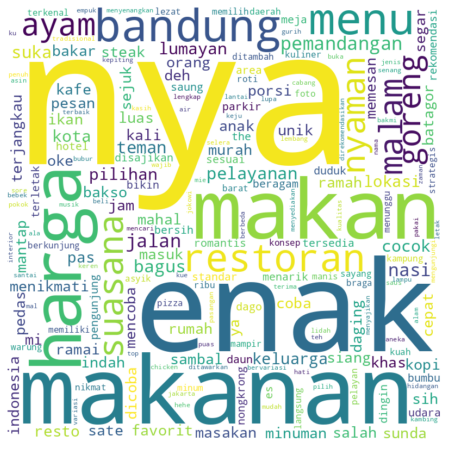

In [ ]:
from wordcloud import WordCloud

# create a list of all words in positive sentiment
pos_words = []
for text in new_df[new_df["Label"]=="positive"]["cleaned_text"].values:
    pos_words.extend(text.split())

# count the frequency of each word
word_freq = Counter(pos_words)

# generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color="white").generate_from_frequencies(word_freq)

# plot the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

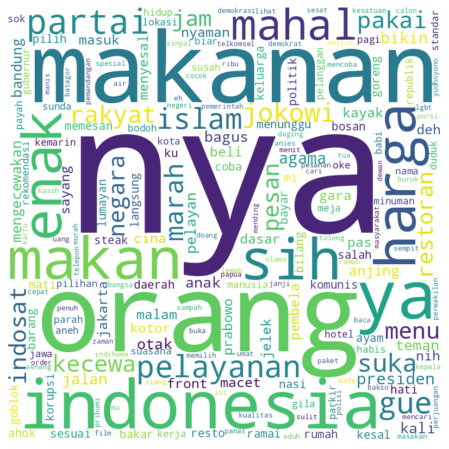

In [ ]:
from wordcloud import WordCloud

# create a list of all words in negative sentiment
pos_words = []
for text in new_df[new_df["Label"]=="negative"]["cleaned_text"].values:
    pos_words.extend(text.split())

# count the frequency of each word
word_freq = Counter(pos_words)

# generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color="white").generate_from_frequencies(word_freq)

# plot the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Preprocessing Lanjutan : remove "nya" dan "ya" 

In [ ]:
def remove_words(df, col):
    # define regex pattern to match "ya" or "nya"
    pattern = r"\b(ya|nya)\b"
    # replace the pattern with empty string
    df.loc[:, col] = df[col].apply(lambda x: re.sub(pattern, "", x))
    return df

cleaned_df = remove_words(new_df, "cleaned_text")

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


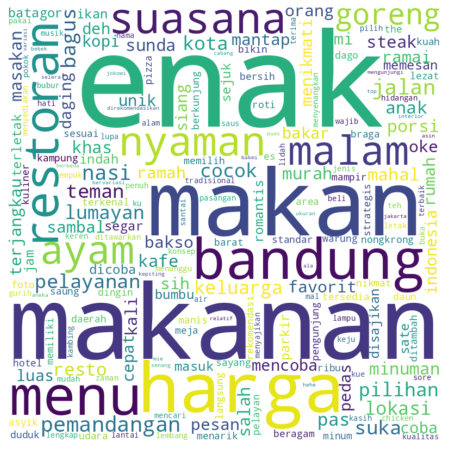

In [ ]:
# akan kita coba untuk visualisasikan kembali
from wordcloud import WordCloud

# create a list of all words in positive sentiment
pos_words = []
for text in new_df[cleaned_df["Label"]=="positive"]["cleaned_text"].values:
    pos_words.extend(text.split())

# count the frequency of each word
word_freq = Counter(pos_words)

# generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color="white").generate_from_frequencies(word_freq)

# plot the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

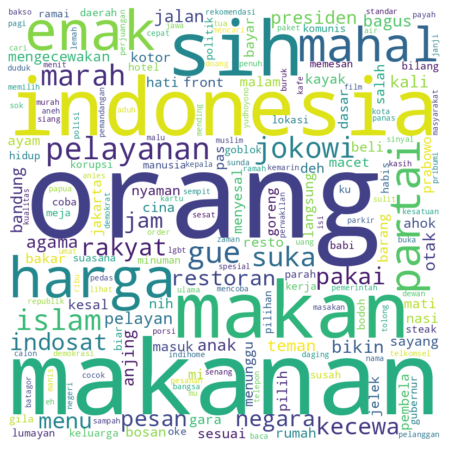

In [ ]:
from wordcloud import WordCloud

# create a list of all words in negative sentiment
pos_words = []
for text in new_df[cleaned_df["Label"]=="negative"]["cleaned_text"].values:
    pos_words.extend(text.split())

# count the frequency of each word
word_freq = Counter(pos_words)

# generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color="white").generate_from_frequencies(word_freq)

# plot the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# save to data training
data_training = cleaned_df.copy()
data_training.head()

,cleaned_text,Label
0,mohon ulama lurus mmbri hujjah partai diwlh suara islam pecah pecah,neutral
1,lokasi strategis jalan sumatra bandung nyaman sofa lantai paella enak pas dimakan minum bir dingin appetiser enak enak,positive
2,betapa bahagia unboxing paket barang bagus menetapkan beli,positive
3,aduh mahasiswa sombong kasih kartu kuning belajar usahlah politik selesai kuliah politik telat dasar mahasiswa,negative
4,makanan beragam harga makanan food stall kasir suasana ramai perhatian parkir duduk,positive


In [ ]:
data_training.columns = ['text', 'label']
data_training.head()

,text,label
0,mohon ulama lurus mmbri hujjah partai diwlh suara islam pecah pecah,neutral
1,lokasi strategis jalan sumatra bandung nyaman sofa lantai paella enak pas dimakan minum bir dingin appetiser enak enak,positive
2,betapa bahagia unboxing paket barang bagus menetapkan beli,positive
3,aduh mahasiswa sombong kasih kartu kuning belajar usahlah politik selesai kuliah politik telat dasar mahasiswa,negative
4,makanan beragam harga makanan food stall kasir suasana ramai perhatian parkir duduk,positive


In [ ]:
data_training.tail()

,text,label
10994,kecewa,positive
10995,enak masakan kepiting menyenangkan memilih kepiting segar mampir bandung,positive
10996,hormati partai partai berkoalisi,neutral
10997,pagi pagi tol pasteur macet parah bikin jengkel,negative
10998,belanja yogyakarta riau juion kali lihat foodlife luas bersih kumuh foodcourt pilihan makanan tradisional makanan barat asian berat ringan tinggal pilih disesuaikan biaya makan,positive


In [ ]:
# display panjang kalimat
text_len = []
for text in data_training.text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

data_training['text_len'] = text_len

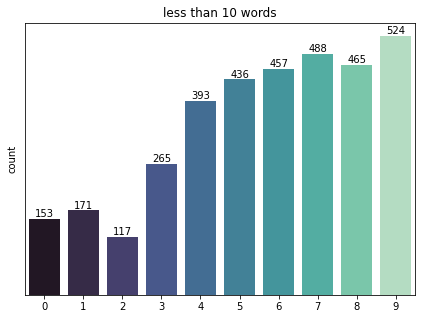

In [ ]:
# display
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=data_training[data_training['text_len'] < 10], palette='mako')
plt.title('less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
# filter berdasarkan panjang kalimat
new_training_data = data_training[data_training['text_len'] > 4]

# print shape data
print(f" DF SHAPE: {df.shape}")

new_training_data = new_training_data[['text', 'label']]

 DF SHAPE: (10999, 3)


## Deep Learning Modelling Process

In [ ]:
new_training_data.head()

,text,label
0,mohon ulama lurus mmbri hujjah partai diwlh suara islam pecah pecah,neutral
1,lokasi strategis jalan sumatra bandung nyaman sofa lantai paella enak pas dimakan minum bir dingin appetiser enak enak,positive
2,betapa bahagia unboxing paket barang bagus menetapkan beli,positive
3,aduh mahasiswa sombong kasih kartu kuning belajar usahlah politik selesai kuliah politik telat dasar mahasiswa,negative
4,makanan beragam harga makanan food stall kasir suasana ramai perhatian parkir duduk,positive


In [ ]:
# process label
def convert_Sentiment(label):
    if label == "neutral":
        return 2
    elif label == "positive":
        return 1
    else:
        return 0

# Apply convert_Sentiment function
new_training_data.label = new_training_data.label.apply(lambda x : convert_Sentiment(x))

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
# check dataset 
print(new_training_data.label.value_counts())
print('*' * 70)

1    6089
0    2793
2    1018
Name: label, dtype: int64
**********************************************************************


## Word Embedding

In [ ]:
import gensim
from gensim.models.fasttext import load_facebook_model
from gensim.test.utils import datapath

path = '/content/drive/MyDrive/BitHealth/idwiki_word2vec_100.model'
model_embedding = gensim.models.word2vec.Word2Vec.load(path)

In [ ]:
# panggil data embedding tambahan
data_embedding = pd.read_csv('/content/drive/MyDrive/BitHealth/data_abusive.csv')
data_embedding.head()

,ABUSIVE
0,alay
1,ampas
2,buta
3,keparat
4,anjing


In [ ]:
# build embedding model
model_embedding.build_vocab(data_embedding['ABUSIVE'], update=True)

In [ ]:
# train embedding model
model_embedding.train(data_embedding['ABUSIVE'], total_examples=model_embedding.corpus_count, epochs=model_embedding.epochs)

(577, 3580)

In [ ]:
# test pre_trained model 
print(model_embedding.wv.most_similar('buta'))

[('tuli', 0.6133606433868408), ('pincang', 0.5916689038276672), ('gila', 0.5860286951065063), ('melek', 0.5770912170410156), ('bodoh', 0.5437142252922058), ('cacat', 0.5410445928573608), ('kerasukan', 0.5370073318481445), ('membabi', 0.5288766026496887), ('cabul', 0.5238915085792542), ('tolol', 0.515395998954773)]


In [ ]:
# Save the updated model
model_embedding.save('updated_model_embedding.w2v')

In [ ]:
# load updated model embedding
new_path = '/content/updated_model_embedding.w2v'
new_model_embedding = gensim.models.word2vec.Word2Vec.load(new_path)

In [ ]:
vocab_size = len(new_model_embedding.wv)
vector_dim = new_model_embedding.vector_size

# Create the embedding matrix
embedding_matrix = np.zeros((vocab_size, vector_dim))
for i in range(vocab_size):
    word = new_model_embedding.wv.index_to_key[i]
    embedding_vector = new_model_embedding.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create the Keras embedding layer
embedding_layer = Embedding(vocab_size, vector_dim, weights=[embedding_matrix], trainable=False)

## Model Configuration

In [ ]:
# split dataset 
X = new_training_data['text']
y = new_training_data['label']

# Tokenize Texts
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X))

list_tokenized_X = tokenizer.texts_to_sequences(X)

maxlen = 2000
X_final = pad_sequences(list_tokenized_X, maxlen=maxlen)

In [ ]:
import pickle

# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 15775


In [ ]:
X_final

array([[   0,    0,    0, ...,   95, 2351, 2351],
       [   0,    0,    0, ..., 5527,    1,    1],
       [   0,    0,    0, ...,   18, 4393,   98],
       ...,
       [   0,    0,    0, ...,   74,  130,    6],
       [   0,    0,    0, ...,  487,   66, 2809],
       [   0,    0,    0, ..., 2243,  768,    3]], dtype=int32)

In [ ]:
y

0        2
1        1
2        1
3        0
4        1
        ..
10989    1
10992    2
10995    1
10997    0
10998    1
Name: label, Length: 9900, dtype: int64

In [ ]:
# Split data into train , test
X_train , X_test , y_train , y_test = train_test_split(X_final,y,test_size=0.2,random_state=0)

In [ ]:
# check dataset
print('Shape of X_train : ' , X_train.shape)
print('Shape of y_train : ', y_train.shape)
print('Shape of X_test : ', X_test.shape)
print('Shape of y_test : ',y_test.shape)

Shape of X_train :  (7920, 2000)
Shape of y_train :  (7920,)
Shape of X_test :  (1980, 2000)
Shape of y_test :  (1980,)


In [ ]:
# Convert y to categorical 
y_train = to_categorical(y_train, 3)
y_test  = to_categorical(y_test, 3)

In [ ]:
y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

### Model : Simple LSTM Model

In [ ]:
# create model 
inp = Input(shape=(maxlen, )) 
x   =  embedding_layer(inp)
x   =  LSTM(128, return_sequences=True,name='lstm_layer')(x)
x   =  GlobalMaxPool1D()(x)
x   =  Dense(64, activation="relu")(x)
x   =  Dropout(0.2)(x)
x   =  Dense(3, activation="softmax")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 embedding (Embedding)       (None, 2000, 100)         42002400  
                                                                 
 lstm_layer (LSTM)           (None, 2000, 128)         117248    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                             

In [ ]:
# train network
model.fit(X_train,y_train, epochs=2,validation_data=(X_test,y_test))

Epoch 1/2
248/248 [==============================] - 956s 4s/step - loss: 0.6017 - accuracy: 0.7479 - val_loss: 0.5462 - val_accuracy: 0.7833
Epoch 2/2
248/248 [==============================] - 954s 4s/step - loss: 0.4472 - accuracy: 0.8280 - val_loss: 0.4774 - val_accuracy: 0.8207


In [ ]:
# Evaluate
model.evaluate(X_test,y_test)

62/62 [==============================] - 79s 1s/step - loss: 0.4774 - accuracy: 0.8207


[0.4774441421031952, 0.8207070827484131]

In [ ]:
#prediksi
sentiment_classes = ['negative', 'neutral', 'positive']
prediction = model.predict(X_test)
prediction_class = [sentiment_classes[np.argmax(pred)] for pred in prediction]
prediction_class

62/62 [==============================] - 84s 1s/step


['negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'negative',
 'negative',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'negative',
 'positive',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'negative',

In [ ]:
# classification report
lstm_pred = np.round(model.predict(X_test))
cr = classification_report(y_test,lstm_pred)
print(cr)

62/62 [==============================] - 84s 1s/step
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       568
           1       0.90      0.90      0.90      1203
           2       0.68      0.46      0.55       209

   micro avg       0.84      0.79      0.82      1980
   macro avg       0.78      0.68      0.72      1980
weighted avg       0.84      0.79      0.81      1980
 samples avg       0.79      0.79      0.79      1980



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Prediksi sentiment dengan unknown dataset

In [ ]:
# import data testing
data_testing = pd.read_csv('/content/drive/MyDrive/BitHealth/data_test.tsv', delimiter='\t' , usecols=lambda col: col != 'Unnamed: 0')
data_testing.head()

,Tweet
0,- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'
1,RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga'
2,"41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpisah, ketika kakakku lebih memilih jadi Kristen. Ketika aku anak ter"
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT TAPI DILIAT DARI MANA ITU AKU'
4,USER USER Kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah'


dataset testing terindikasi uppercase, sehingga kita akan melakukan proses awal dengan menjadikan lowercase terlebih dahulu

In [ ]:
# preprocess data testing
data_testing_lower = data_testing.copy()

# Lowercase string
data_testing_lower = data_testing_lower.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

# ubah nama kolom
data_testing_lower.columns = ['text']

# apply preprocessing
data_testing_lower['cleaned_text'] = data_testing_lower['text'].apply(preprocessing)

# display result
data_testing_lower.head()

,text,cleaned_text
0,- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !',cowok berusaha melacak perhatian gue lantas remehkan perhatian gue kasih khusus basic cowok bego
1,rt user: user siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga',telat tau edan sarap gue bergaul cigax jifla calis licew
2,"41. kadang aku berfikir, kenapa aku tetap percaya pada tuhan padahal aku selalu jatuh berkali-kali. kadang aku merasa tuhan itu ninggalkan aku sendirian. ketika orangtuaku berencana berpisah, ketika kakakku lebih memilih jadi kristen. ketika aku anak ter",kadang berpikir percaya tuhan jatuh berkali kali kadang tuhan meninggalkan orang tuaku berencana berpisah kakakku memilih kristen anak ter
3,user user aku itu aku\n\nku tau matamu sipit tapi diliat dari mana itu aku',daku tau matamu sipit madana
4,user user kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah',kaum cebong kafir dungunya dungu haha


In [ ]:
# filter data testing
new_data_testing_lower = data_testing_lower.copy()
new_data_testing_lower = new_data_testing_lower[['cleaned_text']]
new_data_testing_lower.columns = ['text']
new_data_testing_lower.head()

,text
0,cowok berusaha melacak perhatian gue lantas remehkan perhatian gue kasih khusus basic cowok bego
1,telat tau edan sarap gue bergaul cigax jifla calis licew
2,kadang berpikir percaya tuhan jatuh berkali kali kadang tuhan meninggalkan orang tuaku berencana berpisah kakakku memilih kristen anak ter
3,daku tau matamu sipit madana
4,kaum cebong kafir dungunya dungu haha


In [ ]:
# hilangkan data ya dan nya pada dataset testing lalu hilangkan panjang dataset yang kurang dari 4 kata
cleaned_df_testing = remove_words(new_data_testing_lower, "text")

# display panjang kalimat
text_len = []
for text in cleaned_df_testing.text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

cleaned_df_testing['text_len'] = text_len

# filter dataset
new_testing_data = cleaned_df_testing[cleaned_df_testing['text_len'] > 4]
new_testing_data = cleaned_df_testing[['text']]

# display testing dataset 
new_testing_data.head() 

,text
0,cowok berusaha melacak perhatian gue lantas remehkan perhatian gue kasih khusus basic cowok bego
1,telat tau edan sarap gue bergaul cigax jifla calis licew
2,kadang berpikir percaya tuhan jatuh berkali kali kadang tuhan meninggalkan orang tuaku berencana berpisah kakakku memilih kristen anak ter
3,daku tau matamu sipit madana
4,kaum cebong kafir dungunya dungu haha


In [ ]:
# inisiasi data input
input_testing = new_testing_data['text']

# tokenized
tokenizer_data_testing = Tokenizer(num_words=max_features)
tokenizer_data_testing.fit_on_texts(list(input_testing))

In [ ]:
# session crash

list_tokenized_test = tokenizer_data_testing.texts_to_sequences(input_testing)
# pad sequences
data_prediction = pad_sequences(list_tokenized_test, maxlen=maxlen)

#prediksi
prediction_unknown_data = model.predict(data_prediction)
prediction_class_unknown_data = [sentiment_classes[np.argmax(pred)] for pred in prediction_unknown_data]
prediction_class_unknown_data

NameError: ignored

In [ ]:
# display label prediction
sentiment_labels = ['positive', 'negative', 'neutral']

# Convert the prediction label to sentiment labels
predictions = np.argmax(lstm_pred_data_unknown, axis=1)
sentiments = [sentiment_labels[p] for p in predictions]

# Print the resulting sentiment labels
print(sentiments)

['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'neutral', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'neutral', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'neutr

In [ ]:
# create a new DataFrame with the predicted sentiment labels
df_predictions = pd.DataFrame({'sentiment': sentiments})

# concat the original DataFrame with the new DataFrame
df_hasil_prediksi = pd.concat([new_testing_data, df_predictions], axis=1)

df_hasil_prediksi.head(20)

,text,sentiment
0,cowok berusaha melacak perhatian gue lantas remehkan perhatian gue kasih khusus basic cowok bego,positive
1,telat tau edan sarap gue bergaul cigax jifla calis licew,positive
2,kadang berpikir percaya tuhan jatuh berkali kali kadang tuhan meninggalkan orang tuaku berencana berpisah kakakku memilih kristen anak ter,positive
3,daku tau matamu sipit madana,positive
4,kaum cebong kafir dungunya dungu haha,positive
5,bani taplak kawan kawan,positive
6,deklarasi pilihan kepala daerah aman anti hoaks warga dukuh sari jabon,negative
7,gue selesai re watch aldnoah zero kampret karakter utama cowoknya kena friendzone bro xd uniform resource locator,negative
8,admin belanja saitu port terbaik nak makan ais kepal milo ais kepal horlicks cendol toping kau kau doket gerai rozak merituaku taipan kembar baby amp romantika bank islam senawang,positive
9,enak ngewe,positive


In [ ]:
df_hasil_prediksi.tail(20)

,text,sentiment
13029,foto dadadan dadadanpohodadadan kolodadadani modadadanyet putih dadadan dadaaku lihat modadadanyet emadadadang dadamerasa yadadadang geladadadantudadadangadadadan dadadan dadaaku dimas,negative
13030,tambahan arsitektur universitas katolik parahyangan bandung,positive
13031,komisi nasional hak asasi manusia sontoloyo,negative
13032,rizieq shihab front pembela islam jancuk anjing kontol tempek anjing babi bajingan bangsat lonte balon banci bencong tai cabul pengecut cok teroris bubarkan organisasi masyarakat front pembela islam hizbut tahrir indonesia makar,negative
13033,selamat beruang latar status sosial ekonomi pakaian ang kenakan hanalah perhiasan duniawi topeng belaka kulit jati sebenarna,positive
13034,adik tengok sekeliling adik nak cam agama first impression je cakap muka cina buddha india hindu melayu islam,positive
13035,makadandanya gkamue skamurkamuh baca adanggaradan pedandapatadan dadan beladanja danegara biar bego lihat tkamuh askamumsi harga midanyak adanggaradan pedandapatadan dadan beladanja danegara pakai adangka kdanp revisi adanggaradan pedandapatadan dadan beladanja danegara makadanya jgdan ambil berita adanalisis skamusah sih dangomodang adanodanim bloodan kgkamue,positive
13036,presiden joko widodo jokowi masuk daftar the muslim kepala staf kepresidenan moeldoko menyebut predikat bukti jokowi memperjuangkan kepentingan umat islam tokoh muslim berpengaruh,negative
13037,resep salah gubernur pakkkk presiden presiden got nih lihat percaya,negative
13038,maaf si anu cocoknya mustafa kemal almarhum,positive


In [ ]:
testing_data_input = ['aduh mahasiswa sombong kasih kartu kuning belajar usahlah politik selesai kuliah nya politik telat dasar mahasiswa']

# tokenize this data
tokenizer_data_testing_baru = Tokenizer(num_words=max_features)
tokenizer_data_testing_baru.fit_on_texts(list(testing_data_input))

list_tokenized_test_baru = tokenizer_data_testing_baru.texts_to_sequences(testing_data_input)

# pad sequences
data_prediction_baru = pad_sequences(list_tokenized_test_baru, maxlen=maxlen)
data_prediction_baru

array([[ 0,  0,  0, ..., 13, 14,  1]], dtype=int32)

In [ ]:
# testing function for API 
def predict_sentiment(data_prediction_baru):
    result = model.predict(data_prediction_baru)[0][0]
    if result >= 0.6 :
        return 'positive'
    elif result <= 0.4:
        return "negative"
    else:
        return "neutral"

In [ ]:
predict_sentiment(data_prediction_baru)

1/1 [==============================] - 0s 40ms/step


'negative'

In [ ]:
# predict dataset final
lstm_pred_data_unknown_baru = np.round(model.predict(data_prediction_baru))

1/1 [==============================] - 0s 40ms/step


In [ ]:
# display label prediction
sentiment_labels_baru = ['positive', 'negative', 'neutral']

# Convert the prediction label to sentiment labels
predictions_baru = np.argmax(lstm_pred_data_unknown_baru, axis=1)
sentiments_baru = [sentiment_labels_baru[j] for j in predictions_baru]

# Print the resulting sentiment labels
print(sentiments_baru)

['negative']


## Model Save

In [ ]:
# Save the model to a file
model.save('deep_learning_model_sentiment_analysis.h5')